In [12]:
%load_ext autoreload

import math
import numpy as np
import torch

import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from numpy.lib.stride_tricks import sliding_window_view
from last_layer_models import LLI, train_last_layer_det, get_post_pred_dens
from mc_dropout import MCDropoutNet
from bnn import BNN, train_bnn

np.random.seed(100)

from torch import nn
from tqdm import tqdm

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Probabilistic NNs on 1d regression

We want to visualize the predictions of different probabilistic NNs on 

$y = \sin(x) + \varepsilon$, with $\varepsilon \sim \mathcal{N}(0, \sigma_0^2)$.

## 1. Data
We sample 200 datapoints from the function with $x \in [-4,4]$. \
Then we randomly split the data into 100 points for training and validation, respectively.

Text(0.5, 1.0, 'Training/Validation split')

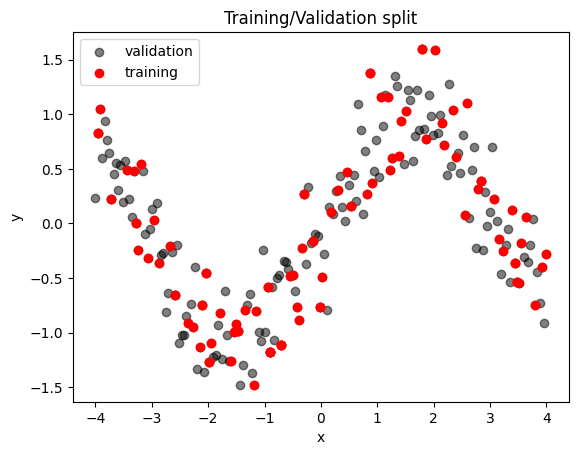

In [13]:
def f(x: float, noise: bool = True, sigma_eps: float = 0.1):
    """Generates a sample y_i from y = sin(x) + varepsilon."""
    y = math.sin(x)
    if noise:
        y += sigma_eps*np.random.randn(1)
    return y

# draw data
sigma_eps = 0.3
xs = np.linspace(-4,4,200)
ys = np.array([f(x = x, noise = True, sigma_eps = sigma_eps) for x in xs])

# sample train indices
train_idx = np.random.randint(0, len(xs), 100)

xs_train = torch.tensor(xs[train_idx]).unsqueeze(-1).float()
ys_train = torch.tensor(ys[train_idx]).float()

# visualize train/val split
fig, axs = plt.subplots(1,1)
axs.scatter(xs, ys, c = 'black', label = 'validation', alpha =.5)
axs.scatter(xs_train, ys_train, c = 'red', label = 'training', alpha = 1)
axs.legend()
axs.set_xlabel('x')
axs.set_ylabel('y')
axs.set_title("Training/Validation split")

Now we create the dataloaders for training and validation

In [14]:
data = TensorDataset(xs_train, ys_train)
train_set, val_set = torch.utils.data.random_split(data, [80, 20])
dataloader_train = DataLoader(train_set, shuffle = True, batch_size=5)
dataloader_val = DataLoader(val_set, shuffle = True, batch_size=20)

## 2. Models
We fit three different models:
- **LLI**: last-layer inference with an isotropic Gaussian prior on $w$ and $\sigma_0^2$ is assumed to be known. This gives a closed-form posterior
- **MC dropout**: Same network as for the LLI, but with dropout layers in between the fully connected layers.
- **BNN**: full BNN trained with Bayes-by-Backprop and isotropic Gaussian priors on the weights.

In [15]:
# all models have 4 layers with 100, 100, 5 and 1 neuron(s), respectively.
model_dims = [1, 100, 100, 100, 50, 1]
num_epochs = 100

### 2.1 LLI

100%|██████████| 100/100 [00:00<00:00, 169.28it/s]


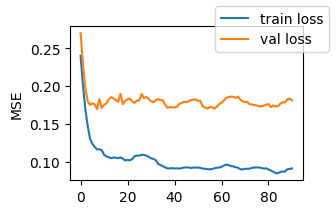

In [16]:
# train deep feature projector psi
lli_net = LLI(model_dims)
sigma_0 = 0.3

lli_net, losses_train, losses_val = train_last_layer_det(model = lli_net, 
                                                         dataloader_train = dataloader_train,
                                                         dataloader_val = dataloader_val, 
                                                         num_epochs = num_epochs)

# plot losses
fig, axs = plt.subplots(1,1, figsize = (3,2))
axs.plot(sliding_window_view(np.array(losses_train), 10).mean(axis=1), label = 'train loss')
axs.plot(sliding_window_view(np.array(losses_val), 10).mean(axis=1), label = 'val loss')
axs.set_ylabel('MSE')
fig.legend()

In [17]:
lli_net.eval()

# fit last-layer posterior
Psi = lli_net.get_ll_embedd(xs_train)
d = Psi.shape[1]
Sigma_N_inv = (1/sigma_0**2)*torch.eye(d) + (1/sigma_eps**2)*(Psi.T @ Psi)
Sigma_N = torch.linalg.inv(Sigma_N_inv).detach()
mu_N = Sigma_N @ ((1/sigma_eps**2)*(Psi.T @ ys_train)).detach()

### 2.2 MC dropout

100%|██████████| 100/100 [00:00<00:00, 147.64it/s]


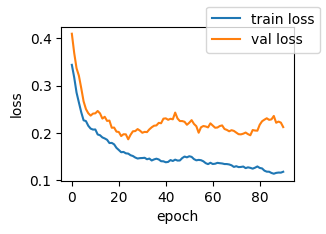

In [18]:
mc_net = MCDropoutNet(model_dims, p = 0.2)

mc_net, losses_train, losses_val = train_last_layer_det(model = mc_net, 
        dataloader_train = dataloader_train,
        dataloader_val = dataloader_val, 
        num_epochs = num_epochs)

# plot losses
fig, axs = plt.subplots(1,1, figsize = (3,2))
axs.plot(sliding_window_view(np.array(losses_train), 10).mean(axis=1), label = 'train loss')
axs.plot(sliding_window_view(np.array(losses_val), 10).mean(axis=1), label = 'val loss')
axs.set_xlabel('epoch')
axs.set_ylabel('loss')
fig.legend()

### 2.3 BNN

In [19]:
import torch
import torch.optim as optim

bnn = BNN()
bnn, losses_train, losses_val = train_bnn(model = bnn, 
                                          num_epochs = num_epochs, 
                                          dataloader_train = dataloader_train, 
                                          dataloader_val = dataloader_val)

100%|██████████| 100/100 [00:03<00:00, 25.06it/s]


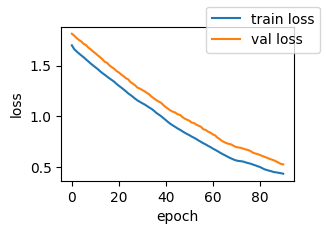

In [20]:
# plot losses
fig, axs = plt.subplots(1,1, figsize = (3,2))
axs.plot(sliding_window_view(np.array(losses_train), 10).mean(axis=1), label = 'train loss')
axs.plot(sliding_window_view(np.array(losses_val), 10).mean(axis=1), label = 'val loss')
axs.set_xlabel('epoch')
axs.set_ylabel('loss')
fig.legend()

## 3. Visualization
We now visualize the predictive means and prediction intervals (mean + 2sd) for all models.

In [21]:
# prediction coordinates:
xs_pred_np = np.linspace(-10,10,200)
xs_pred = torch.tensor(xs_pred_np).unsqueeze(-1).float()

# predictions for:
# LLI:
lli_pred_mu, lli_pred_sigma = get_post_pred_dens(model = lli_net, x_star = xs_pred , 
                              mu_N = mu_N, Sigma_N = Sigma_N, sigma_eps = sigma_0 )
# MC dropout
num_samples_mc_dropout = 100
preds = []
with torch.no_grad():
    for _ in range(num_samples_mc_dropout):
        preds.append(mc_net.forward(xs_pred))

ys_samples_mc = torch.stack(preds)
mc_pred_mu = torch.mean(ys_samples_mc, axis = 0).squeeze()
mc_pred_sigma = torch.std(ys_samples_mc, axis = 0).squeeze()

# BNN
bnn.eval()
with torch.no_grad():
    preds = [bnn(xs_pred) for _ in range(100)]  # 100 MC samples
    preds = torch.stack(preds)
    bnn_pred_mu = preds.mean(dim=0).squeeze()
    bnn_pred_std = preds.std(dim=0).squeeze()

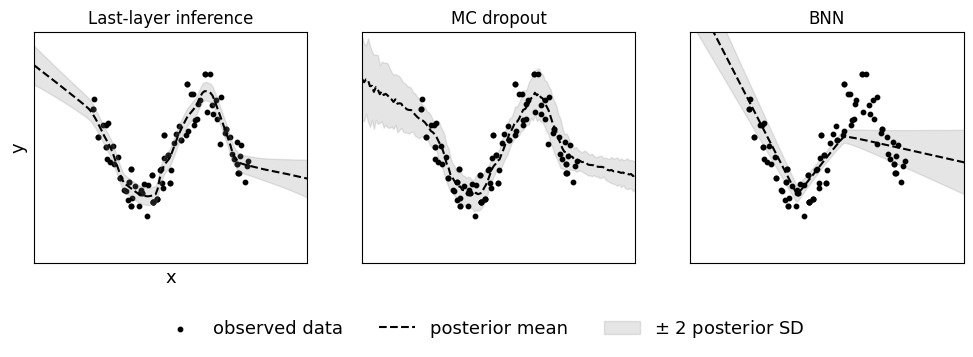

In [22]:
TEXT_SIZE = 13
ys_no_noise = np.array([f(x = x, noise = False, sigma_eps = sigma_eps) for x in xs])

fig, axs = plt.subplots(1,3,figsize=(12, 3))

for i, title, pred_mus, pred_sigmas in zip(range(3), ['Last-layer inference', 'MC dropout', 'BNN'], 
                                           [lli_pred_mu, mc_pred_mu, bnn_pred_mu], 
                                           [lli_pred_sigma, mc_pred_sigma, bnn_pred_std]):
    if i == 0:
        axs[i].scatter(xs_train, ys_train, c = 'black', label = 'observed data', alpha = 1, s = 10)
        axs[i].plot(xs_pred_np, pred_mus, c = 'black', linestyle = 'dashed', label = 'posterior mean')
        axs[i].fill_between(xs_pred_np, pred_mus - 2*pred_sigmas,  pred_mus + 2*pred_sigmas, color = 'grey', label = r'$\pm$ 2 posterior SD', alpha = 0.2)
        axs[i].set_xlabel('x', size = TEXT_SIZE)
        axs[i].set_ylabel('y', size = TEXT_SIZE)
    else: 
        axs[i].fill_between(xs_pred_np, pred_mus - 2*pred_sigmas,  pred_mus + 2*pred_sigmas, color = 'grey', alpha = 0.2)
        axs[i].plot(xs_pred_np, pred_mus, c = 'black', linestyle = 'dashed')
        axs[i].scatter(xs_train, ys_train, c = 'black', alpha = 1, s = 10)
    
    axs[i].set_title(title)
    axs[i].set_xlim(-7,7)
    axs[i].set_ylim(-2.5, 2.5)
    axs[i].set_yticks([], [])
    axs[i].set_xticks([], [])


fig.legend(ncols = 3, loc='lower center', 
           fontsize = TEXT_SIZE, bbox_to_anchor=(0.5, -0.2), frameon=False)
fig.savefig('1d_regression.pdf', bbox_inches=None)